In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

# Import modules
from model import VAE_WGAN
from dataset import get_data_loaders

In [2]:
# CONFIGURATION
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "vae_wgan_final.pth"
RESULTS_DIR = "results_classifier"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
def extract_features_and_labels(model, loader):
    model.eval()
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in tqdm(loader, desc="Extracting Z-vectors"):
            imgs = imgs.to(DEVICE)

            # Extract Latent Vector (Mean)
            mu, _ = model.encoder(imgs)

            features.append(mu.cpu().numpy())
            labels.append(lbls.numpy())

    return np.concatenate(features, axis=0), np.concatenate(labels, axis=0)

--- VAE-WGAN Latent Classification ---

In [4]:
# 1. Load Data
# We need the TEST loader because it has both Fire (1) and Normal (0)
# Ideally, we would split this Test set into "Train Classifier" and "Test Classifier"
_, test_loader = get_data_loaders('modis_dataset_brazil', batch_size=BATCH_SIZE)

Total Normal: 9298
Total Fire: 9299
--- Split Summary ---
Train Set (Normal Only): 7438 images
Test Set (Normal):       1860 images
Test Set (Fire):         1860 images
Total Test Set:          3720 images


In [5]:
# 2. Load Model
model = VAE_WGAN().to(DEVICE)
if not os.path.exists(MODEL_PATH):
    print("Model not found!")

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
print("VAE-WGAN Loaded.")

VAE-WGAN Loaded.


In [6]:
# 3. Extract Z-Vectors
print("Extracting Latent Features from VAE...")
X, y = extract_features_and_labels(model, test_loader)
print(f"Feature Shape: {X.shape}, Label Shape: {y.shape}")

Extracting Latent Features from VAE...


Extracting Z-vectors: 100%|██████████| 59/59 [00:17<00:00,  3.28it/s]

Feature Shape: (3720, 128), Label Shape: (3720,)


In [7]:
# 4. Split Data for the Classifier
# We use 80% of the extracted features to train the Classifier, 20% to test it
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# 5. Train Classifier (Support Vector Machine)
print("Training SVM Classifier on Latent Space...")
clf = SVC(kernel='rbf', probability=True) # RBF Kernel usually works best
clf.fit(X_train, y_train)

Training SVM Classifier on Latent Space...


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [9]:
# 6. Evaluate
print("Evaluating...")
y_pred = clf.predict(X_test)
y_probs = clf.predict_proba(X_test)[:, 1]

Evaluating...


In [10]:
# Metrics
auc_score = roc_auc_score(y_test, y_probs)
print(f"\n================ RESULTS ================")
print(f"Classifier AUC: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Fire']))


================ RESULTS ================
Classifier AUC: 0.8871

Classification Report:
              precision    recall  f1-score   support

      Normal       0.78      0.88      0.83       385
        Fire       0.85      0.74      0.79       359

    accuracy                           0.81       744
   macro avg       0.81      0.81      0.81       744
weighted avg       0.81      0.81      0.81       744



Saved confusion matrix to results_classifier


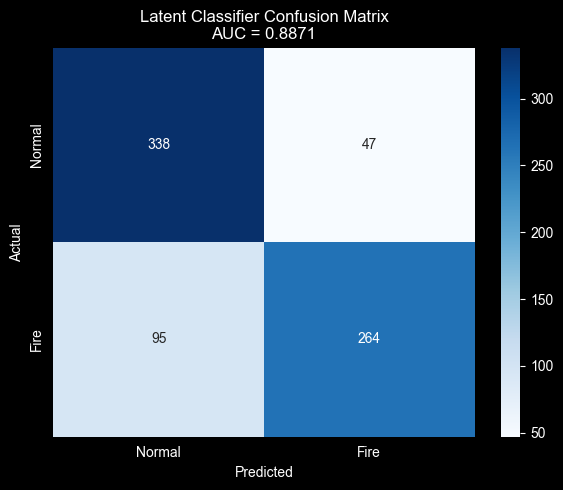

In [11]:
# 7. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fire'], yticklabels=['Normal', 'Fire'])
plt.title(f'Latent Classifier Confusion Matrix\nAUC = {auc_score:.4f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix_svm.png'))
print(f"Saved confusion matrix to {RESULTS_DIR}")